Consider linear problem

$$ y = G \theta + \eta $$

In [ ]:
using LinearAlgebra
using PyPlot
include("../Inversion/IPS.jl")
include("../Inversion/Plot.jl")
include("../Inversion/Utility.jl")
function residual(method_type::String, m_oo, C_oo, m, C)
    if method_type == "gradient_descent"
        # under-determined case
        return -C_oo\(m - m_oo), 1/2.0*(inv(C) - inv(C_oo))
        
    elseif method_type == "natural_gradient_descent"
        # over-determined case
        return -(m - m_oo), C - C*(C_oo\C) 
        
    elseif method_type == "wasserstein_gradient_descent"
        # over-determined case
        return -C_oo\(m - m_oo), 2I - C_oo\C - C/C_oo 

    else
        error("Problem type : ", problem_type, " has not implemented!")
    end
end

function Continuous_Dynamics(method_type::String, m_oo, C_oo, m_0, C_0, Δt, N_t)

    N_θ = length(m_0)
    m = zeros(N_t+1, N_θ)
    C = zeros(N_t+1, N_θ, N_θ)
    
    m[1, :] = m_0
    C[1, :, :] = C_0

    for i = 1:N_t
        dm, dC = residual(method_type, m_oo, C_oo, m[i, :], C[i, :, :])
        m[i+1, :]    = m[i, :] + dm * Δt
        C[i+1, :, :] = C[i, :, :] + dC * Δt
    end

    return m, C
end


# Prior
N_θ = 2
m_0 = [1.0; 1.0]
C_0 = [4.0 0; 0 4.0]

Continuous_Dynamics (generic function with 1 method)

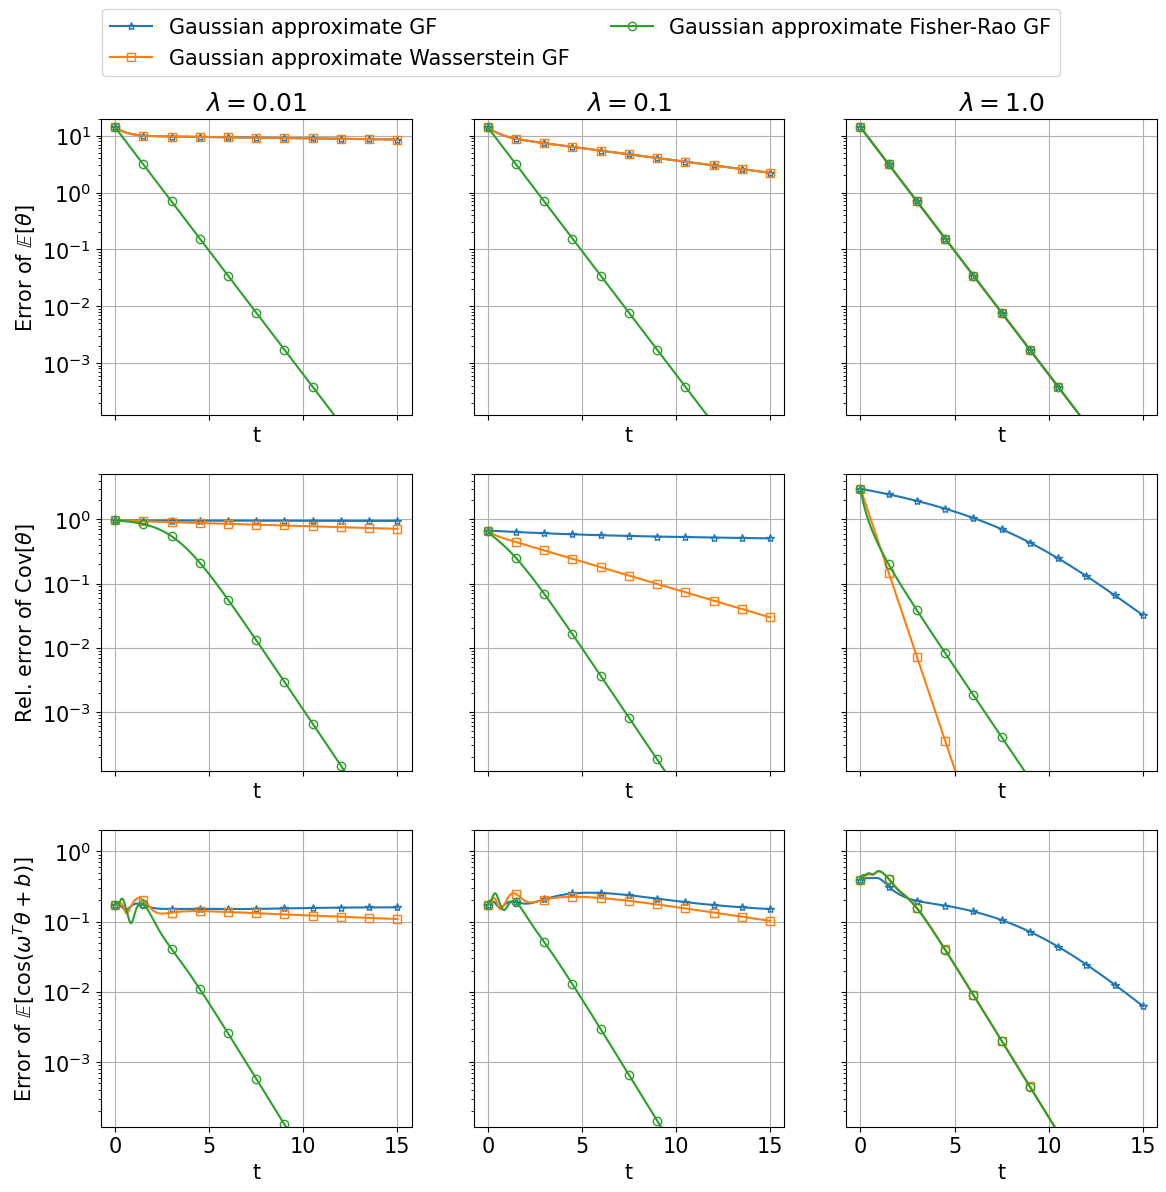

In [ ]:
Random.seed!(42)
Δt, N_t = 5e-3, 3000
ϵs = [0.01, 0.1, 1]
fig, ax = PyPlot.subplots(ncols=3, nrows=3, sharex=true, sharey="row", figsize=(12,12))

ω =  rand(Normal(0, 1), (20, 2))
b = rand(Uniform(0, 2*pi), 20)

ts = LinRange(0, Δt*N_t, N_t+1)

for test_id = 1:length(ϵs)
    ϵ = ϵs[test_id]
    m_oo = [0; 0]
    C_oo = [1 0; 0 1/ϵ]

    m_gd, C_gd   = Continuous_Dynamics("gradient_descent", m_oo, C_oo, m_0, C_0, Δt, N_t)
    m_ngd, C_ngd = Continuous_Dynamics("natural_gradient_descent", m_oo, C_oo, m_0, C_0, Δt, N_t)
    m_wgd, C_wgd = Continuous_Dynamics("wasserstein_gradient_descent", m_oo, C_oo, m_0, C_0, Δt, N_t)

    
    
    cos_ref = cos_error_estimation_particle(m_oo, C_oo, ω, b ) 
    gd_errors    = zeros(N_t+1, 3)
    ngd_errors    = zeros(N_t+1, 3)
    wgd_errors    = zeros(N_t+1, 3)
    
    for i = 1:N_t+1
        m_i, C_i = m_gd[i,:], C_gd[i,:,:]
        gd_errors[i, 1]  = norm(m_i .- m_oo)
        gd_errors[i, 2] = norm(C_i .- C_oo)/norm(C_oo)
        gd_errors[i, 3] = norm(cos_ref - cos_error_estimation_particle(m_i, C_i, ω, b ))/sqrt(length(b))
        
        m_i, C_i = m_ngd[i,:], C_ngd[i,:,:]
        ngd_errors[i, 1]  = norm(m_i .- m_oo)
        ngd_errors[i, 2] = norm(C_i .- C_oo)/norm(C_oo)
        ngd_errors[i, 3] = norm(cos_ref - cos_error_estimation_particle(m_i, C_i, ω, b ))/sqrt(length(b))
        
        m_i, C_i = m_wgd[i,:], C_wgd[i,:,:]
        wgd_errors[i, 1]  = norm(m_i .- m_oo)
        wgd_errors[i, 2] = norm(C_i .- C_oo)/norm(C_oo)
        wgd_errors[i, 3] = norm(cos_ref - cos_error_estimation_particle(m_i, C_i, ω, b ))/sqrt(length(b))
    end
    markevery=div(N_t, 10)
    ax[1, test_id].semilogy(ts, gd_errors[:, 1],  "-*", fillstyle="none", label="Gaussian approximate GF", markevery = markevery)
    ax[1, test_id].semilogy(ts, wgd_errors[:, 1], "-s", fillstyle="none", label="Gaussian approximate Wasserstein GF", markevery = markevery)
    ax[1, test_id].semilogy(ts, ngd_errors[:, 1], "-o", fillstyle="none", label="Gaussian approximate Fisher-Rao GF", markevery = markevery)
            
    ax[2, test_id].semilogy(ts, gd_errors[:, 2],  "-*", fillstyle="none", label="Gaussian approximate GF", markevery = markevery)
    ax[2, test_id].semilogy(ts, wgd_errors[:, 2], "-s", fillstyle="none", label="Gaussian approximate Wasserstein GF", markevery = markevery)
    ax[2, test_id].semilogy(ts, ngd_errors[:, 2], "-o", fillstyle="none", label="Gaussian approximate Fisher-Rao GF", markevery = markevery)
    
    ax[3, test_id].semilogy(ts, gd_errors[:, 3],  "-*", fillstyle="none", label="Gaussian approximate GF", markevery = markevery)
    ax[3, test_id].semilogy(ts, wgd_errors[:, 3], "-s", fillstyle="none", label="Gaussian approximate Wasserstein GF", markevery = markevery)
    ax[3, test_id].semilogy(ts, ngd_errors[:, 3], "-o", fillstyle="none", label="Gaussian approximate Fisher-Rao GF", markevery = markevery)
    
    ax[1, test_id].set_title(L"\lambda = " * string(ϵ))
    ax[1, test_id].set_xlabel("t")
    ax[2, test_id].set_xlabel("t")
    ax[3, test_id].set_xlabel("t")
        
        
    ax[1, test_id].set_ylim([1.2e-4,2.0e1])
    ax[2, test_id].set_ylim([1.2e-4,5.0e0])
    ax[3, test_id].set_ylim([1.2e-4,2.0e0])    
    
    ax[1, test_id].grid("on")
    ax[2, test_id].grid("on")
    ax[3, test_id].grid("on")
end

handles, labels = ax[1,1].get_legend_handles_labels()
fig.legend(handles,labels,loc = "upper center",bbox_to_anchor=(0.5,0.99),ncol=2)
ax[1,1].set_ylabel(L"Error of $\mathbb{E}[\theta]$")
ax[2,1].set_ylabel(L"Rel. error of Cov$[\theta]$")
ax[3,1].set_ylabel(L"Error of $\mathbb{E}[\cos(\omega^T\theta + b)]$")
fig.subplots_adjust(bottom=0.05,top=0.89,left=0.1,right=0.98,hspace=0.2)
fig.savefig("Gaussian_gd_converge.pdf")



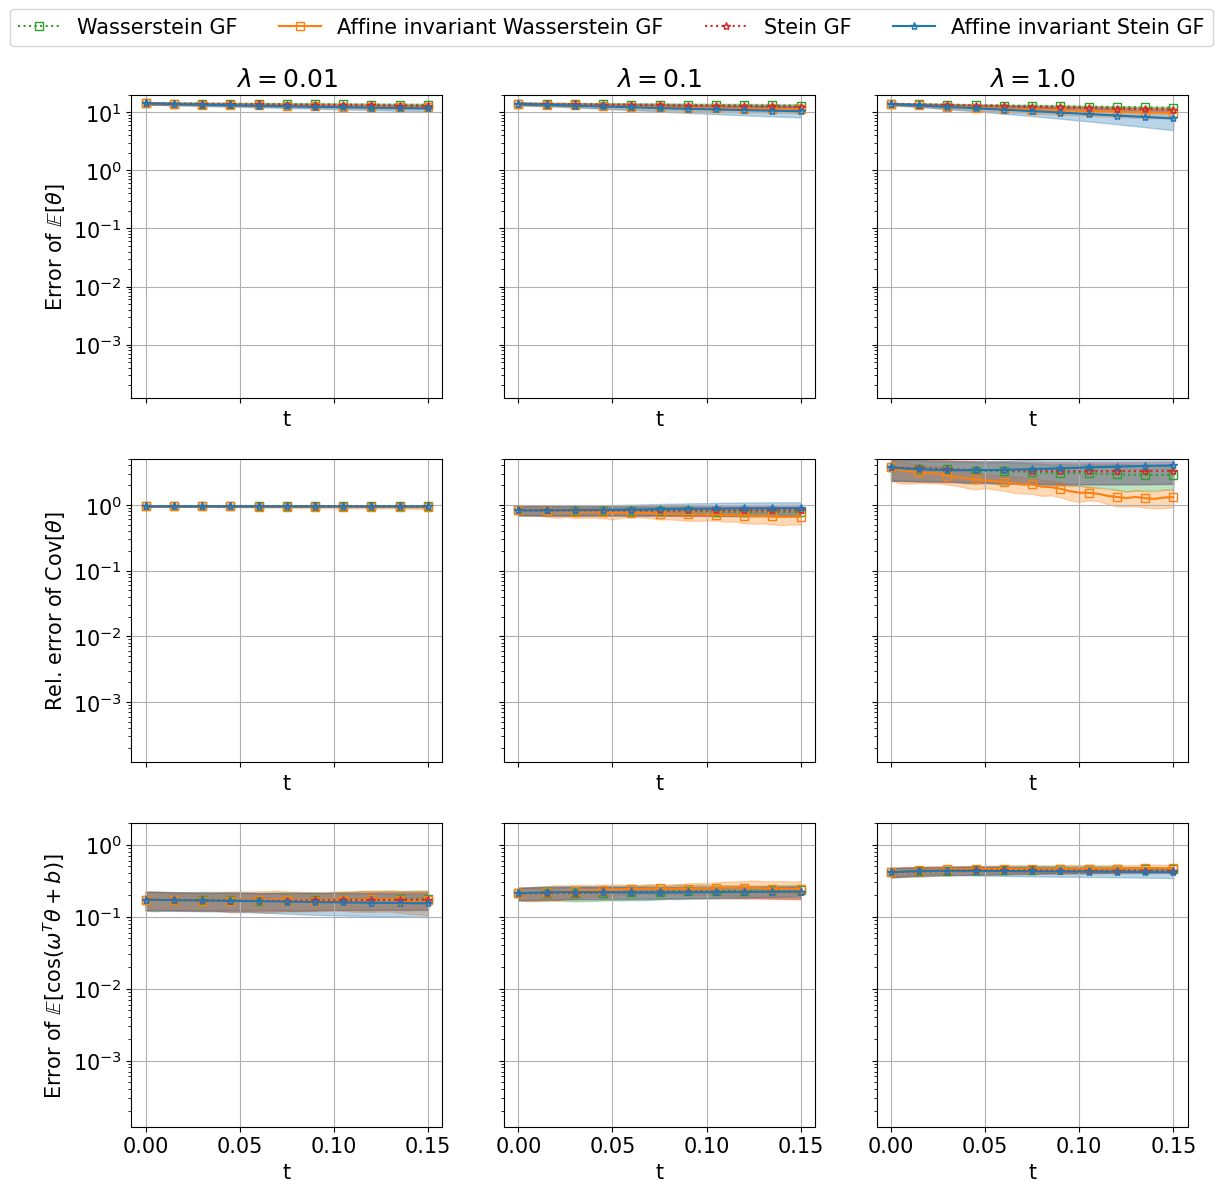

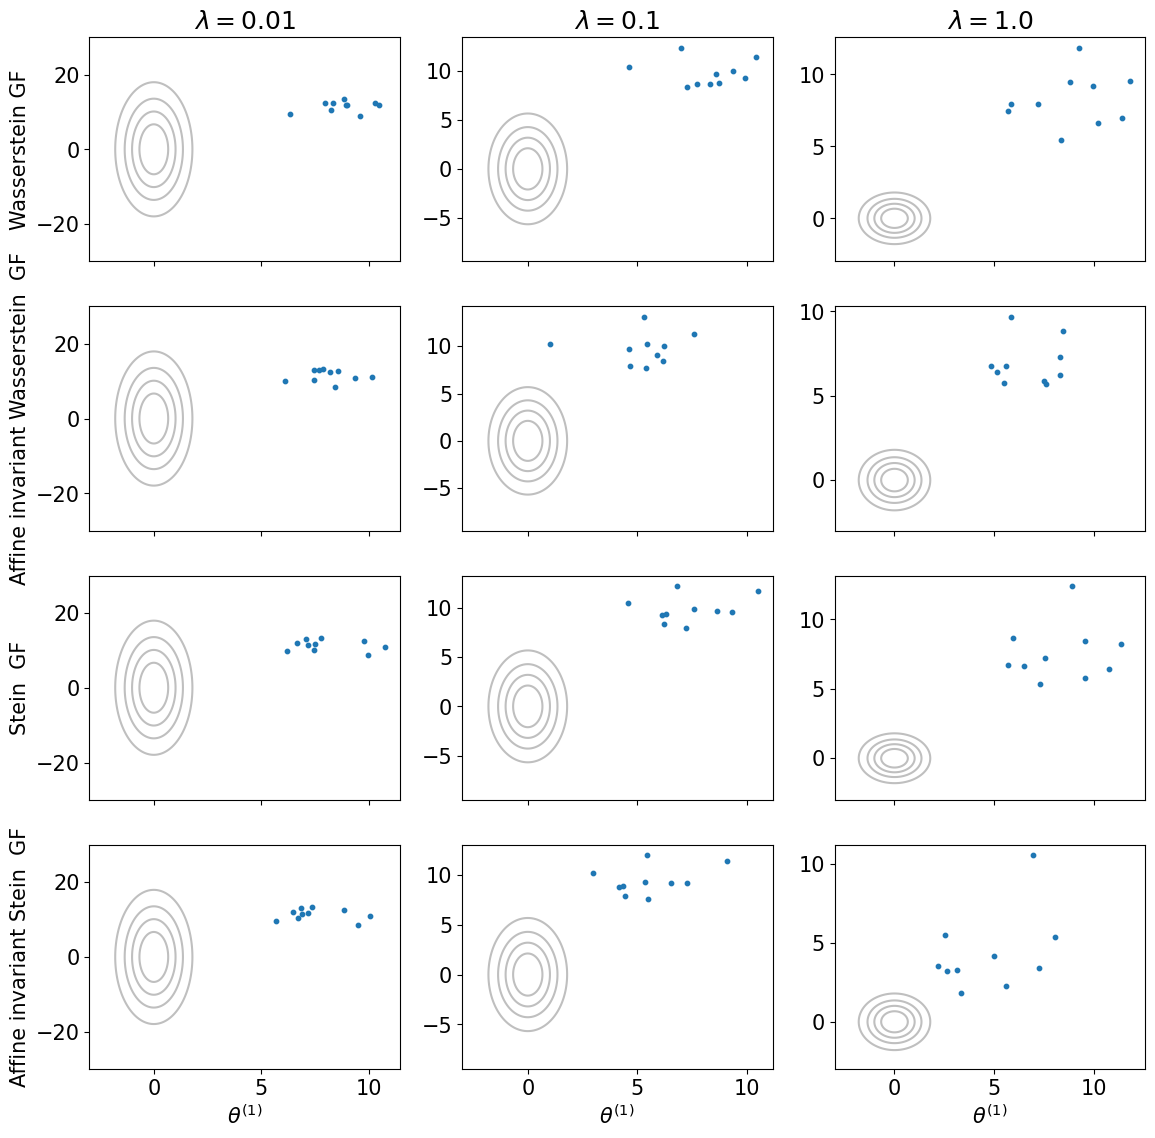

In [ ]:
using Statistics
Random.seed!(42)
######################### TEST #######################################
mutable struct Setup_Param{IT<:Int, VEC, MAT}
    N_θ::IT
    m_oo::VEC
    C_oo::MAT
end

function compute_∇logρ(s_param::Setup_Param, θ::Array{FT, 1}) where {FT<:AbstractFloat}
    C_oo, m_oo = s_param.C_oo, s_param.m_oo
    logρ   = -1/2*(θ - m_oo)'*(C_oo\(θ - m_oo))
    ∇logρ  = -C_oo\(θ - m_oo)
    # ∇²Φ = C_oo
    return logρ, ∇logρ
end




ϵs = [0.01, 0.1, 1]
fig, ax = PyPlot.subplots(ncols=3, nrows=3, sharex=true, sharey="row", figsize=(12,12))
fig_coutour, ax_coutour = PyPlot.subplots(ncols=3, nrows=4, sharex="col", sharey=false, figsize=(12,12))

N_ens = 100
Δt = 0.005
N_t = 3000
ts = LinRange(0, Δt*N_t, N_t+1)
ω =  rand(Normal(0, 1), (20, 2))
b = rand(Uniform(0, 2*pi), 20)
N_repeat = 10


for test_id = 1:length(ϵs)
    ϵ = ϵs[test_id]
    m_oo = [0.0; 0.0]
    C_oo = [1.0 0.0; 0.0 1/ϵ]

    s_param = Setup_Param(N_θ, m_oo, C_oo)
    
    cos_ref = cos_error_estimation_particle(m_oo, C_oo, ω, b ) 


    # Plot reference contour
    logρ(θ) = -0.5*θ'*(C_oo\θ)
    x_min, x_max = -3, 3
    y_min, y_max = -3/sqrt(ϵ), 3/sqrt(ϵ)
    N_x, N_y = 200, 200
    xx_coutour = Array(LinRange(x_min, x_max, N_x))
    yy_coutour = Array(LinRange(y_min, y_max, N_y))
    X_coutour,Y_coutour = repeat(xx_coutour, 1, N_y), repeat(yy_coutour, 1, N_x)'
    Z_coutour = zeros(N_x, N_y)
    for i = 1:N_x
        for j = 1:N_y
            Z_coutour[i, j] = logρ( [X_coutour[i,j], Y_coutour[i,j]] )
        end
    end
    Z_coutour .= exp.(Z_coutour)
    for i = 1:4
        ax_coutour[i, test_id].contour(X_coutour, Y_coutour, Z_coutour, 5, colors="grey", alpha=0.5)
    end

    # Particle simulation
    ips_errors = Dict("Wasserstein" => zeros(N_repeat, 2, N_t+1, 3), "Stein" => zeros(N_repeat, 2, N_t+1, 3))
    for id_repeat = 1:N_repeat
        θ0 = Array(rand(MvNormal(m_0, C_0), N_ens)')

        for method in ["Wasserstein", "Stein"]
            for preconditioner in [false, true]
        
                ips_obj = IPS_Run(s_param, compute_∇logρ, θ0, N_ens, Δt, N_t, method, preconditioner)
    
                for i = 1:N_t+1
                    m_i, C_i = dropdims(mean(ips_obj.θ[i], dims=1), dims=1), construct_cov(ips_obj.θ[i])
                    ips_errors[method][id_repeat, 1 + Int(preconditioner), i, 1] = norm(m_i .- m_oo)
                    ips_errors[method][id_repeat, 1 + Int(preconditioner), i, 2] = norm(C_i .- C_oo)/norm(C_oo)
                    ips_errors[method][id_repeat, 1 + Int(preconditioner), i, 3] = norm(cos_ref - cos_error_estimation_particle(m_i, C_i, ω, b ))/sqrt(length(b))
                end
    
                # For the first repeat, visualize in the contour plot
                if id_repeat == 1
                    if (method == "Wasserstein" && ~preconditioner)
                        ax_coutour[1, test_id].scatter(ips_obj.θ[end][:, 1], ips_obj.θ[end][:, 2], s = 10)
                    elseif (method == "Wasserstein" && preconditioner)
                        ax_coutour[2, test_id].scatter(ips_obj.θ[end][:, 1], ips_obj.θ[end][:, 2], s = 10)
                    elseif (method == "Stein" && ~preconditioner)
                        ax_coutour[3, test_id].scatter(ips_obj.θ[end][:, 1], ips_obj.θ[end][:, 2], s = 10)
                    else 
                        ax_coutour[4, test_id].scatter(ips_obj.θ[end][:, 1], ips_obj.θ[end][:, 2], s = 10)
                    end
                end
            end
        end
    end

    ###########  Error plot
    ites = Array(0:N_t)
    markevery = div(N_t, 10)
    
    for method in ["Wasserstein", "Stein"]
        for preconditioner in [false, true]
            if (method  == "Wasserstein" || method  == "Stein")
                label = (preconditioner ? "Affine invariant "*method : method) * " GF"
                color = (method  == "Stein" ? "C0" : "C1")
                if method  ==  "Wasserstein" && ~preconditioner
                    color  = "C2"
                end
                if method  ==  "Stein" && ~preconditioner
                    color  = "C3"
                end
                
                marker = (method  == "Stein" ? "*" : "s")
            end
            linestyle = preconditioner ?  "solid" : "dotted"
        
            for id_statistics = 1:3
                mean_f = mean(ips_errors[method][:, 1 + Int(preconditioner), : , id_statistics], dims=1)[:]
                std_f  = std( ips_errors[method][:, 1 + Int(preconditioner), : , id_statistics], dims=1)[:]
            
                ax[id_statistics, test_id].semilogy(ts, mean_f, linestyle=linestyle, color=color, marker=marker, fillstyle="none", label=label, markevery = markevery)
                # ax[id_statistics, test_id].errorbar(ts, mean_f, yerr=[mean_f .- std_f, mean_f .+ std_f],
                #          linestyle=linestyle,
                #          markevery = markevery,
                #          marker=marker,
                #          label=label,
                #          color=color)
                ax[id_statistics, test_id].fill_between(ts, mean_f .- std_f, mean_f .+ std_f, color=color, alpha=0.3)
                ax[id_statistics, test_id].set_yscale("log")
            end
        end
    end
            

    
    ax_coutour[1, test_id].set_title(L"\lambda = " * string(ϵ))            
    ax[1, test_id].set_title(L"\lambda = " * string(ϵ))
    ax[1, test_id].set_xlabel("t")
    ax[2, test_id].set_xlabel("t")
    ax[3, test_id].set_xlabel("t")
    
    ax[1, test_id].grid("on")
    ax[2, test_id].grid("on")
    ax[3, test_id].grid("on")
    
    
    ax[1, test_id].set_ylim([1.2e-3,2.0e1])
    ax[2, test_id].set_ylim([1.2e-3,1.0e1])
    ax[3, test_id].set_ylim([1.2e-3,2.0e0])  
        
    ax_coutour[4,test_id].set_xlabel(L"\theta^{(1)}")
end

handles, labels = ax[1,1].get_legend_handles_labels()
fig.legend(handles, labels, loc = "upper center", bbox_to_anchor=(0.5,0.99), ncol=4)
ax[1,1].set_ylabel(L"Error of $\mathbb{E}[\theta]$")
ax[2,1].set_ylabel(L"Rel. error of Cov$[\theta]$")
ax[3,1].set_ylabel(L"Error of $\mathbb{E}[\cos(\omega^T\theta + b)]$")

fig.subplots_adjust(bottom=0.05,top=0.91,left=0.1,right=0.98,hspace=0.2)
fig.savefig("Gaussian_gd_particle_converge.pdf")

ax_coutour[1, 1].set_ylabel("Wasserstein GF")
ax_coutour[2, 1].set_ylabel("Affine invariant Wasserstein  GF")
ax_coutour[3, 1].set_ylabel("Stein  GF")
ax_coutour[4, 1].set_ylabel("Affine invariant Stein  GF")
fig_coutour.subplots_adjust(bottom=0.05,top=0.91,left=0.1,right=0.98,hspace=0.2)
fig_coutour.savefig("Gaussian_gd_particle_contour.pdf")
